# Aplicação do algoritmo

In [105]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error
from timeseriesmetrics import theil
import pandas as pd

models_label_teresina = []
models_MAPE_teresina = []
models_MAE_teresina = []
models_R2_teresina = []
models_theil_teresina = []
    
# Função para calcular as métricas para Fortaleza
def computeAccuracyModels_teresina(model_name, y_pred, y_true):

    
    # Adiciona o nome do modelo
    models_label_teresina.append(model_name)
    
    # Convertendo para arrays unidimensionais
    y_pred = y_pred.values  # Se y_pred for um DataFrame ou Series
    y_true = y_true.values.ravel()  # Converte y_true para uma array unidimensional
    
    # Tratamento de NaN: Remove os dois primeiros valores (caso sejam NaN)
    y_pred_clean = y_pred[2:]
    y_true_clean = y_true[2:]

    # Cálculo das métricas de erro
    mae = mean_absolute_error(y_true_clean, y_pred_clean)
    mape = mean_absolute_percentage_error(y_true_clean, y_pred_clean)
    r2 = r2_score(y_true_clean, y_pred_clean)
    theil_value = theil(y_true_clean, y_pred_clean)

    # Armazenando os resultados
    models_MAE_teresina.append(mae)
    models_MAPE_teresina.append(mape)
    models_R2_teresina.append(r2)
    models_theil_teresina.append(theil_value)
    
    # Exibindo o DataFrame com os resultados ordenados por MAE
    df = pd.DataFrame({
        'Model': models_label_teresina,
        'MAE': models_MAE_teresina,
        'MAPE': models_MAPE_teresina,
        'R2': models_R2_teresina,
        'Theil': models_theil_teresina
    })
    
    print(" --------------------------- Medidas de Erro para teresina  --------------------------- ") 
    print(df.sort_values(by='MAE', ascending=True))

models_label_salvador = []
models_MAPE_salvador = []
models_MAE_salvador = []
models_R2_salvador = []
models_theil_salvador = []
    
# Função para calcular as métricas para Salvador
def computeAccuracyModels_salvador(model_name, y_pred, y_true):

    # Adiciona o nome do modelo
    models_label_salvador.append(model_name)
    
    # Convertendo para arrays unidimensionais
    y_pred = y_pred.values  # Se y_pred for um DataFrame ou Series
    y_true = y_true.values.ravel()  # Converte y_true para uma array unidimensional
    
    # Tratamento de NaN: Remove os dois primeiros valores (caso sejam NaN)
    y_pred_clean = y_pred[2:]
    y_true_clean = y_true[2:]

    # Cálculo das métricas de erro
    mae = mean_absolute_error(y_true_clean, y_pred_clean)
    mape = mean_absolute_percentage_error(y_true_clean, y_pred_clean)
    r2 = r2_score(y_true_clean, y_pred_clean)
    theil_value = theil(y_true_clean, y_pred_clean)

    # Armazenando os resultados
    models_MAE_salvador.append(mae)
    models_MAPE_salvador.append(mape)
    models_R2_salvador.append(r2)
    models_theil_salvador.append(theil_value)
    
    # Exibindo o DataFrame com os resultados ordenados por MAE
    df = pd.DataFrame({
        'Model': models_label_salvador,
        'MAE': models_MAE_salvador,
        'MAPE': models_MAPE_salvador,
        'R2': models_R2_salvador,
        'Theil': models_theil_salvador
    })
    
    print(" --------------------------- Medidas de Erro para Salvador  --------------------------- ") 
    print(df.sort_values(by='MAE', ascending=True))

models_label_fortaleza = []
models_MAPE_fortaleza = []
models_MAE_fortaleza = []
models_R2_fortaleza = []
models_theil_fortaleza = []
# Função para calcular as métricas para Teresina
def computeAccuracyModels_fortaleza(model_name, y_pred, y_true):

    
    # Adiciona o nome do modelo
    models_label_fortaleza.append(model_name)
    
    # Convertendo para arrays unidimensionais
    y_pred = y_pred.values  # Se y_pred for um DataFrame ou Series
    y_true = y_true.values.ravel()  # Converte y_true para uma array unidimensional
    
    # Tratamento de NaN: Remove os dois primeiros valores (caso sejam NaN)
    y_pred_clean = y_pred[2:]
    y_true_clean = y_true[2:]

    # Cálculo das métricas de erro
    mae = mean_absolute_error(y_true_clean, y_pred_clean)
    mape = mean_absolute_percentage_error(y_true_clean, y_pred_clean)
    r2 = r2_score(y_true_clean, y_pred_clean)
    theil_value = theil(y_true_clean, y_pred_clean)

    # Armazenando os resultados
    models_MAE_fortaleza.append(mae)
    models_MAPE_fortaleza.append(mape)
    models_R2_fortaleza.append(r2)
    models_theil_fortaleza.append(theil_value)
    
    # Exibindo o DataFrame com os resultados ordenados por MAE
    df = pd.DataFrame({
        'Model': models_label_fortaleza,
        'MAE': models_MAE_fortaleza,
        'MAPE': models_MAPE_fortaleza,
        'R2': models_R2_fortaleza,
        'Theil': models_theil_fortaleza
    })
    
    print(" --------------------------- Medidas de Erro para Teresina  --------------------------- ") 
    print(df.sort_values(by='MAE', ascending=True))

models_label_saoluis = []
models_MAPE_saoluis = []
models_MAE_saoluis = []
models_R2_saoluis = []
models_theil_saoluis = []
# Função para calcular as métricas para São Luís
def computeAccuracyModels_saoluis(model_name, y_pred, y_true):
    
    # Adiciona o nome do modelo
    models_label_saoluis.append(model_name)
    
    # Convertendo para arrays unidimensionais
    y_pred = y_pred.values  # Se y_pred for um DataFrame ou Series
    y_true = y_true.values.ravel()  # Converte y_true para uma array unidimensioninal
    
    # Tratamento de NaN: Remove os dois primeiros valores (caso sejam NaN)
    y_pred_clean = y_pred[2:]
    y_true_clean = y_true[2:]

    # Cálculo das métricas de erro
    mae = mean_absolute_error(y_true_clean, y_pred_clean)
    mape = mean_absolute_percentage_error(y_true_clean, y_pred_clean)
    r2 = r2_score(y_true_clean, y_pred_clean)
    theil_value = theil(y_true_clean, y_pred_clean)

    # Armazenando os resultados
    models_MAE_saoluis.append(mae)
    models_MAPE_saoluis.append(mape)
    models_R2_saoluis.append(r2)
    models_theil_saoluis.append(theil_value)
    
    # Exibindo o DataFrame com os resultados ordenados por MAE
    df = pd.DataFrame({
        'Model': models_label_saoluis,
        'MAE': models_MAE_saoluis,
        'MAPE': models_MAPE_saoluis,
        'R2': models_R2_saoluis,
        'Theil': models_theil_saoluis
    })
    
    print(" --------------------------- Medidas de Erro para São Luís  --------------------------- ") 
    print(df.sort_values(by='MAE', ascending=True))


models_label_joaopessoa = []
models_MAPE_joaopessoa = []
models_MAE_joaopessoa = []
models_R2_joaopessoa = []
models_theil_joaopessoa = []
# Função para calcular as métricas para João Pessoa
def computeAccuracyModels_joaopessoa(model_name, y_pred, y_true):
    
    # Adiciona o nome do modelo
    models_label_joaopessoa.append(model_name)
    
    # Convertendo para arrays unidimensionais
    y_pred = y_pred.values  # Se y_pred for um DataFrame ou Series
    y_true = y_true.values.ravel()  # Converte y_true para uma array unidimensioninal
    
    # Tratamento de NaN: Remove os dois primeiros valores (caso sejam NaN)
    y_pred_clean = y_pred[2:]
    y_true_clean = y_true[2:]

    # Cálculo das métricas de erro
    mae = mean_absolute_error(y_true_clean, y_pred_clean)
    mape = mean_absolute_percentage_error(y_true_clean, y_pred_clean)
    r2 = r2_score(y_true_clean, y_pred_clean)
    theil_value = theil(y_true_clean, y_pred_clean)

    # Armazenando os resultados
    models_MAE_joaopessoa.append(mae)
    models_MAPE_joaopessoa.append(mape)
    models_R2_joaopessoa.append(r2)
    models_theil_joaopessoa.append(theil_value)
    
    # Exibindo o DataFrame com os resultados ordenados por MAE
    df = pd.DataFrame({
        'Model': models_label_joaopessoa,
        'MAE': models_MAE_joaopessoa,
        'MAPE': models_MAPE_joaopessoa,
        'R2': models_R2_joaopessoa,
        'Theil': models_theil_joaopessoa
    })
    
    print(" --------------------------- Medidas de Erro para João Pessoa  --------------------------- ") 
    print(df.sort_values(by='MAE', ascending=True))



In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [107]:
dados_salvador = pd.read_csv("data/Salvador_week.csv")
dados_fortaleza = pd.read_csv("data/Fortaleza_week.csv")
dados_teresina = pd.read_csv("data/Teresina_week.csv")
dados_saoluis = pd.read_csv("data/SaoLuis_week.csv")
dados_joaopessoa = pd.read_csv("data/JoaoPessoa_week.csv")
dados_natal = pd.read_csv("data/Natal_week.csv")

In [108]:
#salvador
dados_salvador['Data da Coleta'] = pd.to_datetime(dados_salvador['Data da Coleta'])
dados_salvador = dados_salvador.set_index('Data da Coleta')
#fortaleza
dados_fortaleza['Data da Coleta'] = pd.to_datetime(dados_fortaleza['Data da Coleta'])
dados_fortaleza = dados_fortaleza.set_index('Data da Coleta')
# teresina
dados_teresina['Data da Coleta'] = pd.to_datetime(dados_teresina['Data da Coleta'])
dados_teresina = dados_teresina.set_index('Data da Coleta')
#sao luis
dados_saoluis['Data da Coleta'] = pd.to_datetime(dados_saoluis['Data da Coleta'])
dados_saoluis = dados_saoluis.set_index('Data da Coleta')
#joao pessoa
dados_joaopessoa['Data da Coleta'] = pd.to_datetime(dados_joaopessoa['Data da Coleta'])
dados_joaopessoa = dados_joaopessoa.set_index('Data da Coleta')
# Natal
dados_natal['Data da Coleta'] = pd.to_datetime(dados_natal['Data da Coleta'])
dados_natal = dados_natal.set_index('Data da Coleta')

## Pre-Processamento

In [109]:
from sklearn.pipeline import Pipeline
import pandas as pd

# Lista das séries temporais em um dicionário
dados_series = {
    "salvador": dados_salvador,
    "fortaleza": dados_fortaleza,
    "teresina": dados_teresina,
    "saoluis": dados_saoluis,
    "joaopessoa": dados_joaopessoa,
    "natal": dados_natal
}

# Definindo as colunas numéricas
numeric_features = ['Ano', 'Mes', 'Valor de Venda']

# Criando o pipeline sem pré-processamento
pipeline = Pipeline(steps=[
    ('passthrough', 'passthrough')  # Nenhum pré-processamento necessário
])

# Dicionário para armazenar os resultados transformados
series_transformadas = {}

# Iterando sobre as séries temporais
for nome, dados in dados_series.items():
    # Separando as features e o target
    X = dados[numeric_features]
    y = dados['Valor de Venda']
    
    # Aplicando o pipeline e transformando os dados
    X_transformed = pipeline.fit_transform(X)
    
    # Convertendo a matriz transformada para DataFrame
    X_transformed_df = pd.DataFrame(X_transformed, 
                                    columns=numeric_features,
                                    index=X.index)
    
    # Armazenando a série transformada no dicionário de resultados
    series_transformadas[nome] = {
        "X_transformed": X_transformed_df,
        "y": y
    }

# Acessando os resultados

X_fortaleza = series_transformadas["fortaleza"]["X_transformed"]
y_fortaleza = series_transformadas["fortaleza"]["y"]

X_salvador = series_transformadas["salvador"]["X_transformed"]
y_salvador = series_transformadas["salvador"]["y"]

X_joaopessoa = series_transformadas["joaopessoa"]["X_transformed"]
y_joaopessoa = series_transformadas["joaopessoa"]["y"]

X_saoluis = series_transformadas["saoluis"]["X_transformed"]
y_saoluis = series_transformadas["saoluis"]["y"]

X_teresina = series_transformadas["teresina"]["X_transformed"]
y_teresina = series_transformadas["teresina"]["y"]

X_natal = series_transformadas["natal"]["X_transformed"]
y_natal = series_transformadas["natal"]["y"]



## Análise de Autocorrelação

In [110]:
'''fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(211)
fig = plot_acf(X['Valor de Venda'], lags=60, ax=ax1)
ax1.set_title("Autocorrelação dos lags anteriores")

ax2 = fig.add_subplot(212)
fig = plot_pacf(X['Valor de Venda'], lags=60, ax=ax2)
ax2.set_title("Autocorrelação Parcial dos lags anteriores")'''

#plt.show


'fig = plt.figure(figsize=(12,7))\nax1 = fig.add_subplot(211)\nfig = plot_acf(X[\'Valor de Venda\'], lags=60, ax=ax1)\nax1.set_title("Autocorrelação dos lags anteriores")\n\nax2 = fig.add_subplot(212)\nfig = plot_pacf(X[\'Valor de Venda\'], lags=60, ax=ax2)\nax2.set_title("Autocorrelação Parcial dos lags anteriores")'

## Modelagem

## Gradient Descendent Online in ridge regression

Calculando Random Walk para salvador
Calculando Random Walk para fortaleza
Calculando Random Walk para teresina
Calculando Random Walk para sao_luis
Calculando Random Walk para joao_pessoa
Calculando Random Walk para natal


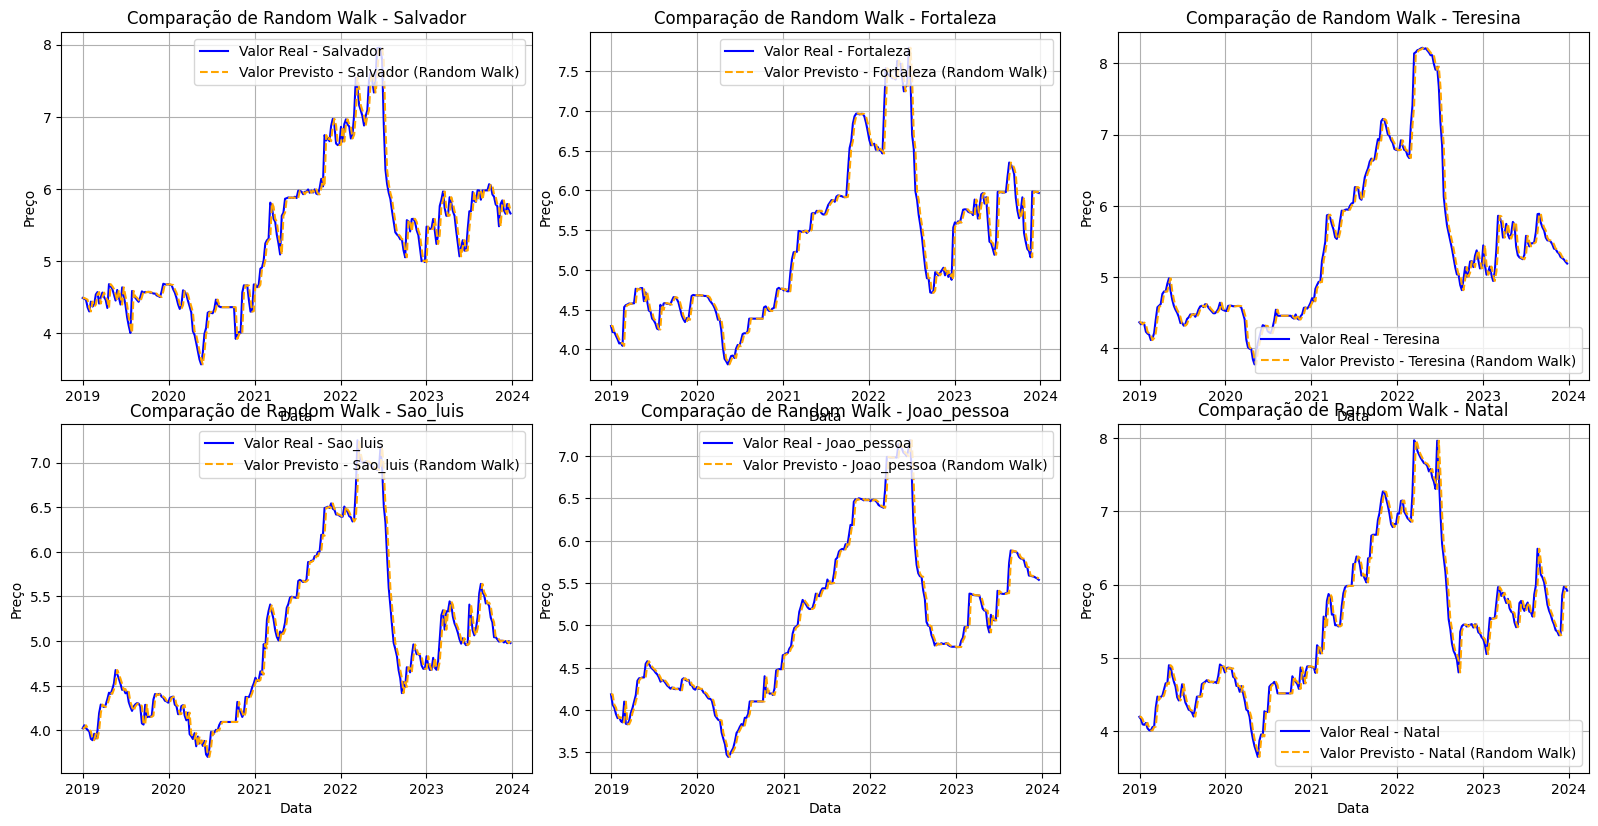

In [111]:
import matplotlib.pyplot as plt

# Função para aplicar Random Walk em múltiplas séries temporais
def random_walk_forecast_multiple(series_dict):
    forecast_results = {}
    
    for city_name, series in series_dict.items():
        print(f"Calculando Random Walk para {city_name}")
        
        # Previsão usando Random Walk
        y_forecast = series.shift(1)
        y_forecast.iloc[0] = series.iloc[0]  # Ajuste o primeiro valor para evitar NaN
        
        # Armazenar as previsões separadas para cada cidade
        forecast_results[city_name] = y_forecast
    
    return forecast_results


# Dicionário com as séries temporais de cada cidade
series_dict = {
    'salvador': dados_salvador['Valor de Venda'],
    'fortaleza': dados_fortaleza['Valor de Venda'],
    'teresina': dados_teresina['Valor de Venda'],
    'sao_luis': dados_saoluis['Valor de Venda'],
    'joao_pessoa': dados_joaopessoa['Valor de Venda'],
    'natal': dados_natal['Valor de Venda']
}

# Aplicar Random Walk em todas as séries
forecasts = random_walk_forecast_multiple(series_dict)

# Agora podemos acessar as previsões para cada cidade separadamente
y_forecast_salvador = forecasts['salvador']
y_forecast_fortaleza = forecasts['fortaleza']
y_forecast_teresina = forecasts['teresina']
y_forecast_saoluis = forecasts['sao_luis']
y_forecast_joaopessoa = forecasts['joao_pessoa']
y_forecast_natal = forecasts['natal']

# Número de cidades (para calcular a grade de subplots)
cities = list(series_dict.keys())
n_cities = len(cities)

# Definir número de colunas e linhas para os subgráficos (grade)
n_cols = 3  # 3 colunas
n_rows = (n_cities + 1) // n_cols  # Número de linhas baseado no número de cidades

# Criar subgráficos
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))

# Ajustar o layout para garantir que os subgráficos não se sobreponham
plt.tight_layout()

# Plotar as previsões para todas as séries
for i, city_name in enumerate(cities):
    row = i // n_cols  # Determinar a linha do subplot
    col = i % n_cols  # Determinar a coluna do subplot
    
    ax = axes[row, col] if n_rows > 1 else axes[col]  # Selecionar o eixo correto
    
    # Plotar valores reais e previstos para a cidade
    ax.plot(series_dict[city_name], label=f'Valor Real - {city_name.capitalize()}', color='blue')
    ax.plot(forecasts[city_name], label=f'Valor Previsto - {city_name.capitalize()} (Random Walk)', linestyle='--', color='orange')
    
    # Títulos e legendas
    ax.set_title(f'Comparação de Random Walk - {city_name.capitalize()}')
    ax.set_xlabel('Data')
    ax.set_ylabel('Preço')
    ax.legend()
    ax.grid(True)

# Exibir os gráficos
plt.show()




In [112]:
# Exemplo de uso para calcular as métricas do modelo 'Random Walk' para cada cidade

# Fortaleza
computeAccuracyModels_fortaleza(model_name='Random Walk', y_pred=y_forecast_fortaleza, y_true=y_fortaleza)

# Salvador
computeAccuracyModels_salvador(model_name='Random Walk', y_pred=y_forecast_salvador, y_true=y_salvador)

# Teresina
computeAccuracyModels_teresina(model_name='Random Walk', y_pred=y_forecast_teresina, y_true=y_teresina)

# São Luís
computeAccuracyModels_saoluis(model_name='Random Walk', y_pred=y_forecast_saoluis, y_true=y_saoluis)

# João Pessoa
computeAccuracyModels_joaopessoa(model_name='Random Walk', y_pred=y_forecast_joaopessoa, y_true=y_joaopessoa)


 --------------------------- Medidas de Erro para Teresina  --------------------------- 
         Model      MAE      MAPE        R2  Theil
0  Random Walk  0.08101  0.014699  0.975373    1.0
 --------------------------- Medidas de Erro para Salvador  --------------------------- 
         Model       MAE      MAPE       R2  Theil
0  Random Walk  0.110894  0.020566  0.96803    1.0
 --------------------------- Medidas de Erro para teresina  --------------------------- 
         Model       MAE      MAPE        R2  Theil
0  Random Walk  0.081317  0.014847  0.985357    1.0
 --------------------------- Medidas de Erro para São Luís  --------------------------- 
         Model       MAE      MAPE        R2  Theil
0  Random Walk  0.074001  0.014766  0.983583    1.0
 --------------------------- Medidas de Erro para João Pessoa  --------------------------- 
         Model      MAE      MAPE        R2  Theil
0  Random Walk  0.05262  0.010519  0.989225    1.0


In [ ]:
from sklearn.preprocessing import StandardScaler

# Calcular resíduos (erro entre a série original e a previsão)
residuos_serie = y_true - y_forecast

# Construir variáveis lagged para previsão
# `X_residual_1` será o resíduo defasado em um ponto
# `X_residual_2` será o resíduo defasado em dois pontos
X_residual_1 = residuos_serie.shift(1)
X_residual_2 = residuos_serie.shift(2)

# Ajustar os valores iniciais ausentes para consistência
X_residual_1.iloc[0] = X_residual_1.iloc[1]  # Ajustar o primeiro valor
X_residual_2.iloc[:2] = X_residual_1.iloc[1]  # Ajustar os dois primeiros valores de X_residual_2

# Concatenar as defasagens em um único DataFrame para escalonamento
X_residual = pd.concat([X_residual_1, X_residual_2], axis=1)
X_residual.columns = ['Lag_1', 'Lag_2']


# Escalar os dados para manter consistência com o modelo anterior
scaler_residual = StandardScaler()
X_residual_scaled = scaler_residual.fit_transform(X_residual.values)

y_residual = residuos_serie.loc[X_residual.index]



In [ ]:
print("residuos forecast",len(y_forecast))
print("residuos",len(y_true))


y_residual_1 = residuos_serie.shift(1)

# Ajustar os valores iniciais ausentes para consistência
y_residual_1.iloc[0] = y_residual_1.iloc[1]  # Ajustar o primeiro valor


residuos forecast 222
residuos 222


In [ ]:
print(len(X_residual))
print(len(y_residual))

222
222


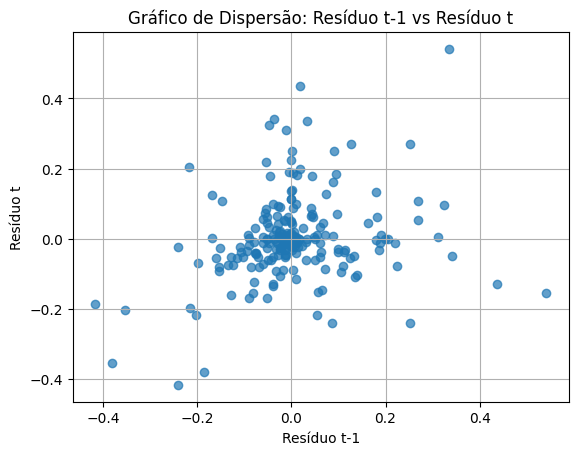

In [ ]:
plt.scatter(y_residual_1,y_residual, alpha=0.7)
plt.title("Gráfico de Dispersão: Resíduo t-1 vs Resíduo t")
plt.xlabel("Resíduo t-1")
plt.ylabel("Resíduo t")
plt.grid(True)
plt.show()

# usar regressão linear pra prever os residuos

In [ ]:
'''df = pd.DataFrame(
    {
         'valor dos residuos': residuos_serie,
         'residuos com lag(1)':X_residual
    }
)'''

"df = pd.DataFrame(\n    {\n         'valor dos residuos': residuos_serie,\n         'residuos com lag(1)':X_residual\n    }\n)"

In [ ]:
'''df.corr()'''

'df.corr()'

## NORMA-Dictionario

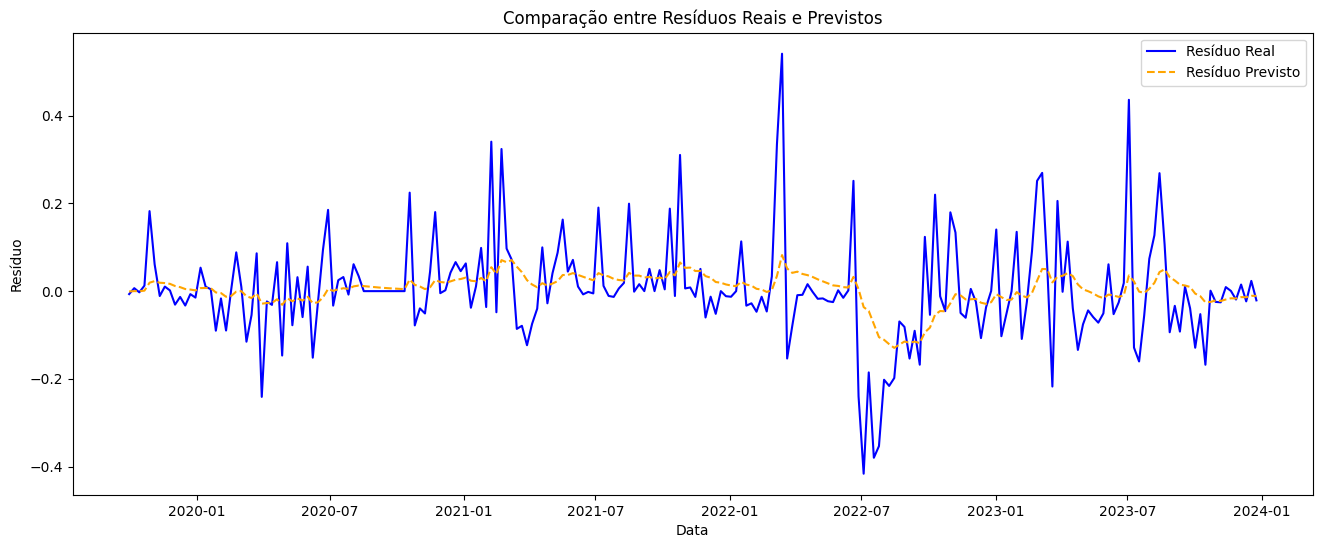

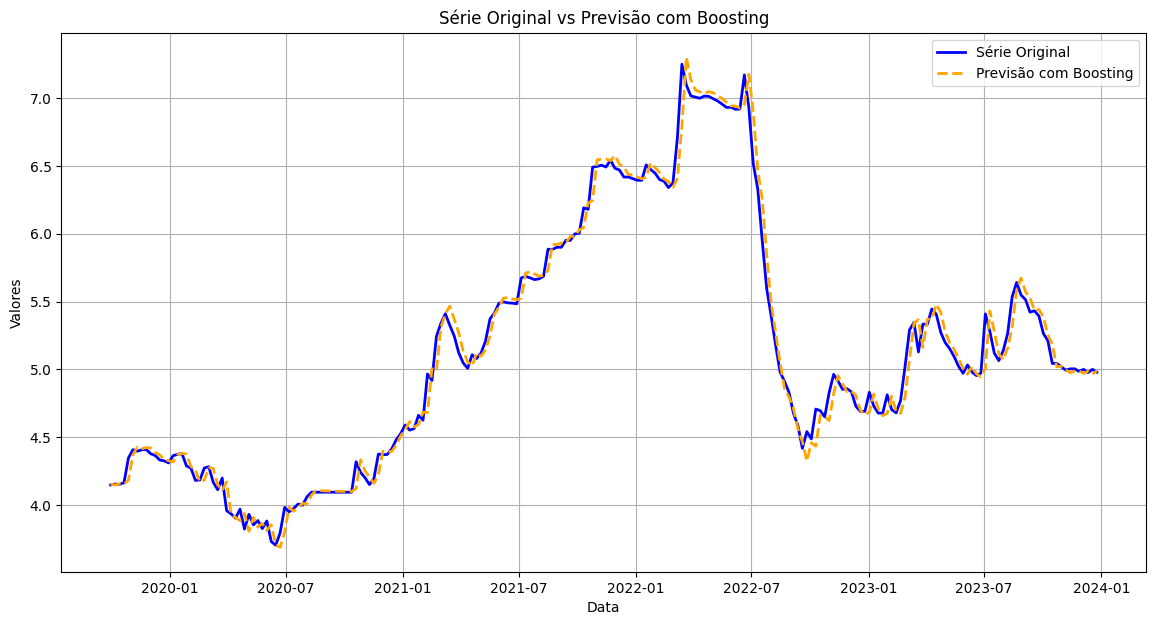

 --------------------------- Medidas de Erro para os Modelos  --------------------------- 
                     model       MAE      MAPE        R2     theil
1  Boosting with NORM-DICT  0.070709  0.013655  0.986304  0.792651
0              Randon Walk  0.075830  0.014760  0.982722  1.000000


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from norm import RidgeSGDKernelTorchDict

# Supondo que seus dados residuais estejam em `y_residual` e `X_residual`
# Converter os dados em dicionários para serem compatíveis com o modelo, utilizando o índice de `y_residual`
X_residual_dict = {idx: x for idx, x in zip(y_residual.index, X_residual.values)}
y_residual_dict = {idx: y for idx, y in zip(y_residual.index, y_residual.values)}

# Instanciar o modelo com os parâmetros desejados
ridge_sgd_torch = RidgeSGDKernelTorchDict(eta=0.1, c=0.1, sigma=1.0)

# Lista para armazenar previsões
y_pred = {}

# Treinar e prever de forma online com os dados residuais
for idx in X_residual_dict.keys():
    x_new = X_residual_dict[idx]
    y_new = y_residual_dict[idx]

    # Atualizar o modelo com o novo ponto
    ridge_sgd_torch.partial_fit(x_new, y_new, idx)

    # Fazer a previsão
    prediction = ridge_sgd_torch.predict(x_new)
    y_pred[idx] = prediction

# Converter as previsões em um pandas.Series para facilitar o plot
y_pred_series = pd.Series(y_pred).sort_index()
y_residual_series = pd.Series(y_residual_dict).sort_index()

# Visualizar os resultados
plt.figure(figsize=(16, 6))
plt.plot(y_residual_series, label='Resíduo Real', color='blue')
plt.plot(y_pred_series, label='Resíduo Previsto', linestyle='--', color='orange')
plt.title('Comparação entre Resíduos Reais e Previstos')
plt.xlabel('Data')
plt.ylabel('Resíduo')
plt.legend()
plt.show()



import matplotlib.pyplot as plt

# Supondo que `y_original` seja sua série original para comparar com a previsão ajustada
# Combine as previsões
y_boosted_forecast_norm_dict = y_forecast + y_pred_series

# Plotando a série original e a previsão ajustada com boosting
plt.figure(figsize=(14, 7))

# Plot da série original
plt.plot(y_true.index, y_true, label='Série Original', color='blue', linewidth=2)

# Plot da previsão com boosting
plt.plot(y_pred_series.index, y_boosted_forecast_norm_dict, label='Previsão com Boosting', color='orange', linestyle='--', linewidth=2)

# Configurações do gráfico
plt.xlabel('Data')
plt.ylabel('Valores')
plt.title('Série Original vs Previsão com Boosting')
plt.legend()
plt.grid(True)
plt.show()



computeAccuracyModels(models='Boosting with NORM-DICT', y_pred=y_boosted_forecast_norm_dict,y_true=y_true)


## Bayes Search

Melhores parâmetros: OrderedDict([('c', 0.6899999999999998), ('eta', 0.8), ('sigma', 0.4)])
Melhor score: 0.016805669450418153


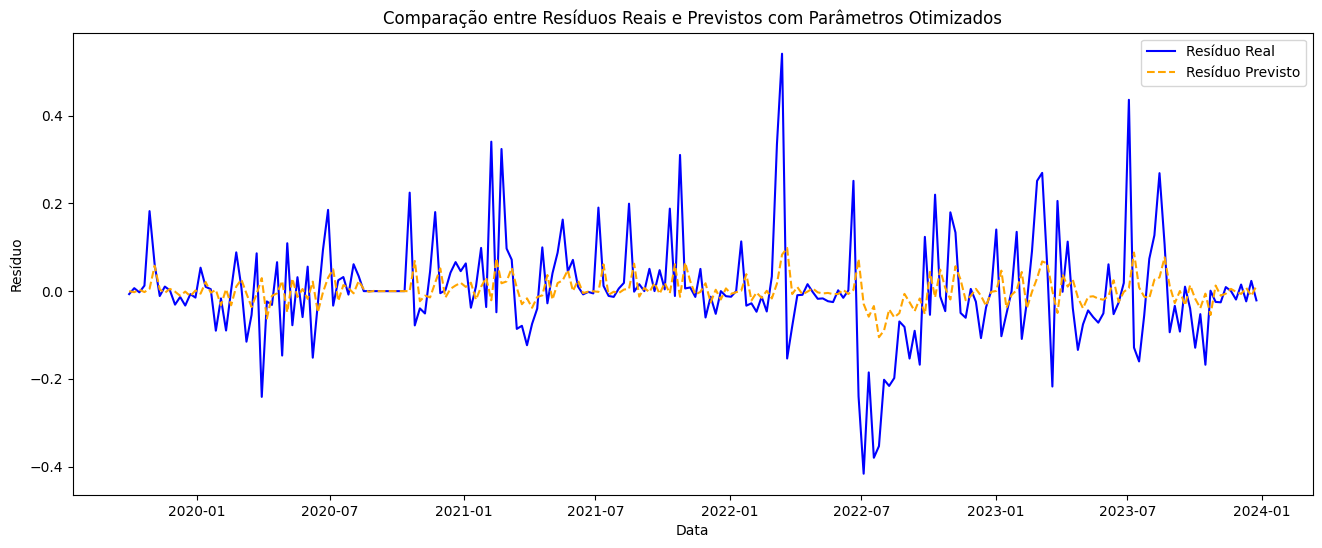

In [ ]:

from skopt import BayesSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
from ridge_sgd_kernel import RidgeSGDKernelTorch

# Adaptar a classe para que funcione com BayesSearchCV
class RidgeSGDKernelTorchWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, eta=0.01, c=0.01, sigma=1.0):
        self.eta = eta
        self.c = c
        self.sigma = sigma
        self.model = None

    def fit(self, X, y):
        # Inicializar o modelo
        self.model = RidgeSGDKernelTorch(eta=self.eta, c=self.c, sigma=self.sigma)
        # Treinar online
        for x_new, y_new in zip(X, y):
            self.model.partial_fit(x_new, y_new)
        return self

    def predict(self, X):
        # Realizar previsões
        return np.array([self.model.predict(x) for x in X])

# Definir o espaço de busca dos hiperparâmetros
param_grid = {
    'eta': (0.6, 0.8, 'log-uniform'),
    'c': (0.01,0.69, 'log-uniform'),
    'sigma': (0.4, 2.0, 'uniform')
}


# Implementar o BayesSearchCV
# TimeSeriesSplit é utilizado para manter a sequência temporal durante a validação cruzada
bayes_search = BayesSearchCV(
    RidgeSGDKernelTorchWrapper(),
    search_spaces=param_grid,
    n_iter=30,  # Número de iterações da busca bayesiana
    cv=TimeSeriesSplit(n_splits=3),  # Validação cruzada para séries temporais
    scoring='neg_mean_squared_error',  # Função de perda (erro quadrático médio)
    n_jobs=-1
)

# Realizar a busca
bayes_search.fit(X_residual.values, y_residual.values)

# Exibir os melhores parâmetros encontrados
print("Melhores parâmetros:", bayes_search.best_params_)
print("Melhor score:", -bayes_search.best_score_)


# Obter os melhores parâmetros da busca
best_eta = bayes_search.best_params_['eta']
best_c = bayes_search.best_params_['c']
best_sigma = bayes_search.best_params_['sigma']

# Criar e treinar o modelo com os melhores parâmetros encontrados
ridge_sgd_torch_best = RidgeSGDKernelTorch(eta=best_eta, c=best_c, sigma=best_sigma)

# Lista para armazenar previsões
y_pred_best = []

# Treinar e prever de forma online com os dados residuais
for x_new, y_new in zip(X_residual.values, y_residual.values):
    ridge_sgd_torch_best.partial_fit(x_new, y_new)  # Atualiza o modelo com o novo ponto
    prediction = ridge_sgd_torch_best.predict(x_new)  # Faz a previsão imediatamente após o ajuste
    y_pred_best.append(prediction)

# Previsões indexadas para facilitar o plot
y_pred_bayes_indexed = pd.Series(y_pred_best, index=y_residual.index)

# Visualizar os resultados
plt.figure(figsize=(16, 6))
plt.plot(y_residual, label='Resíduo Real', color='blue')
plt.plot(y_pred_bayes_indexed, label='Resíduo Previsto', linestyle='--', color='orange')
plt.title('Comparação entre Resíduos Reais e Previstos com Parâmetros Otimizados')
plt.xlabel('Data')
plt.ylabel('Resíduo')
plt.legend()
plt.show()

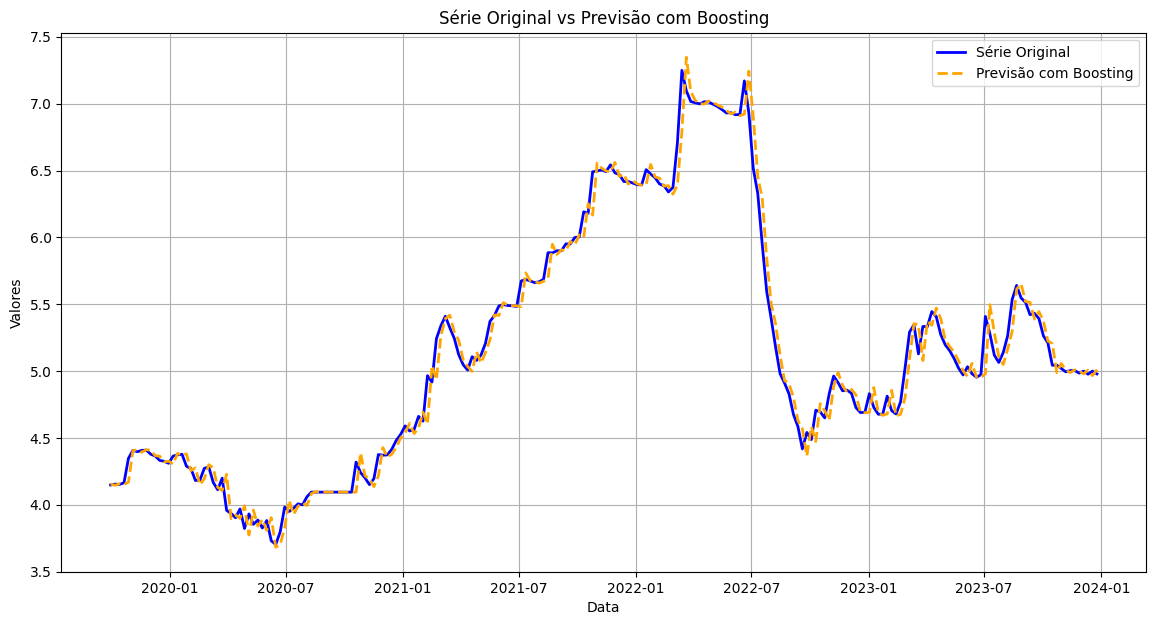

In [ ]:
import matplotlib.pyplot as plt

# Supondo que `y_original` seja sua série original para comparar com a previsão ajustada
# Combine as previsões
y_boosted_forecast_bayes = y_forecast + y_pred_bayes_indexed

# Plotando a série original e a previsão ajustada com boosting
plt.figure(figsize=(14, 7))

# Plot da série original
plt.plot(y_true.index, y_true, label='Série Original', color='blue', linewidth=2)

# Plot da previsão com boosting
plt.plot(y_pred_bayes_indexed.index, y_boosted_forecast_bayes, label='Previsão com Boosting', color='orange', linestyle='--', linewidth=2)

# Configurações do gráfico
plt.xlabel('Data')
plt.ylabel('Valores')
plt.title('Série Original vs Previsão com Boosting')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:

computeAccuracyModels(models='Boosting with bayes-NORMA', y_pred=y_boosted_forecast_bayes,y_true=y_true)

 --------------------------- Medidas de Erro para os Modelos  --------------------------- 
                       model       MAE      MAPE        R2     theil
1    Boosting with NORM-DICT  0.070709  0.013655  0.986304  0.792651
0                Randon Walk  0.075830  0.014760  0.982722  1.000000
2  Boosting with bayes-NORMA  0.076115  0.014875  0.983537  0.952843


In [ ]:
X_residual

,Lag_1,Lag_2
Data da Coleta,,
2019-09-30,-0.006768,-0.006768
2019-10-07,-0.006768,-0.006768
2019-10-14,0.006768,-0.006768
2019-10-21,-0.002726,0.006768
2019-10-28,0.012546,-0.002726
...,...,...
2023-11-27,0.000482,0.009184
2023-12-04,-0.019167,0.000482
2023-12-11,0.015000,-0.019167


## Arima 

In [ ]:
X_residual = X_residual.drop(columns='Lag_2')

In [ ]:
X_residual

,Lag_1
Data da Coleta,
2019-09-30,-0.006768
2019-10-07,-0.006768
2019-10-14,0.006768
2019-10-21,-0.002726
2019-10-28,0.012546
...,...
2023-11-27,0.000482
2023-12-04,-0.019167
2023-12-11,0.015000


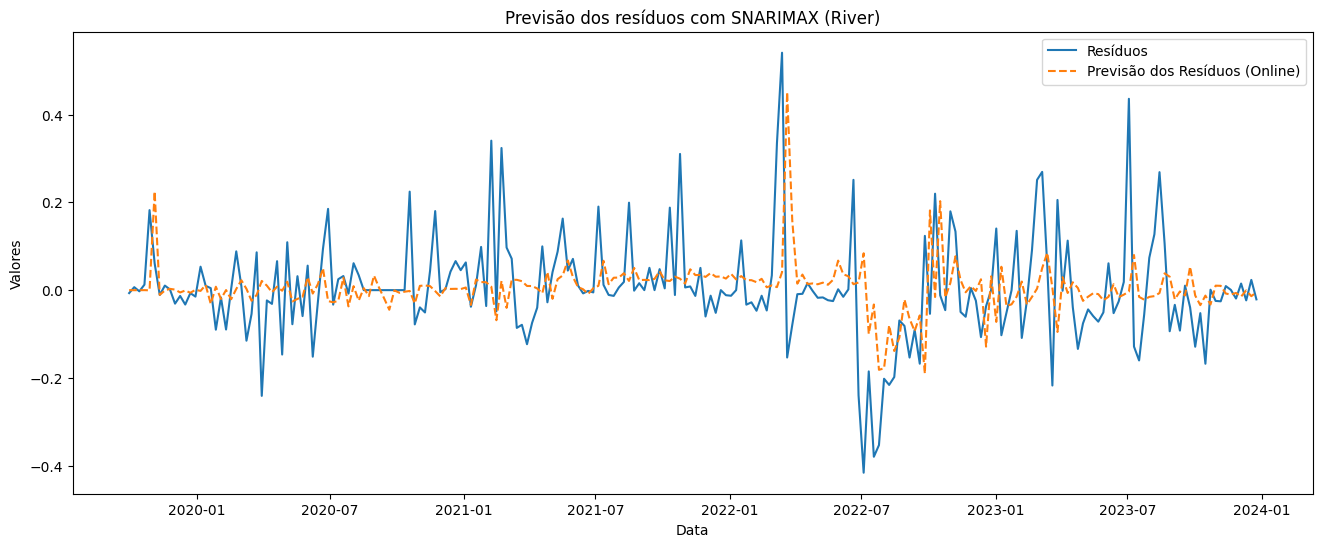

In [ ]:
from river.time_series import SNARIMAX
import pandas as pd
import matplotlib.pyplot as plt

# Inicializar o modelo SNARIMAX
model = SNARIMAX(
    p=1, d=0, q=1, 
    m=12,  # Ajuste a sazonalidade conforme necessário (ex.: 12 para sazonalidade anual em dados mensais)
    sp=1, sd=0, sq=1
)

# Lista para armazenar as previsões iterativas
predictions_online = []

# Prever um ponto de cada vez e atualizar o modelo
for i in range(len(y_residual)):
    # Obter o valor real atual
    real_value = y_residual.iloc[i]
    
    # Fazer a previsão com o modelo (horizon=1 para prever um ponto)
    prediction = model.forecast(horizon=1)
    
    # Armazenar a previsão
    predictions_online.append(prediction[0])  # Como forecast retorna uma lista, pegamos o primeiro valor
    
    # Atualizar o modelo com a observação real
    model.learn_one(real_value)

# Convertendo as previsões para uma série
prediction_series_online = pd.Series(predictions_online, index=y_residual.index)

# Plotar os resultados
plt.figure(figsize=(16, 6))
plt.plot(y_residual.index, y_residual, label='Resíduos')
plt.plot(prediction_series_online.index, prediction_series_online, label='Previsão dos Resíduos (Online)', linestyle='--')
plt.title('Previsão dos resíduos com SNARIMAX (River)')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.legend()
plt.show()




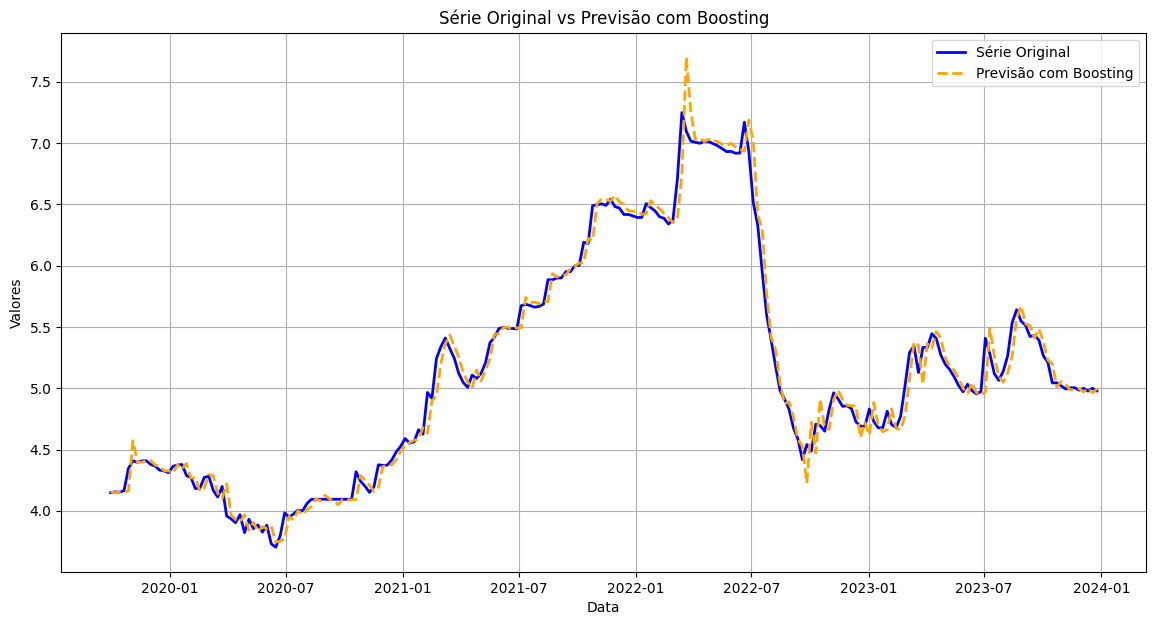

In [ ]:

# Supondo que `y_original` seja sua série original para comparar com a previsão ajustada
# Combine as previsões
y_boosted_forecast_arima = y_forecast + prediction_series_online

# Plotando a série original e a previsão ajustada com boosting
plt.figure(figsize=(14, 7))

# Plot da série original
plt.plot(y_true.index, y_true, label='Série Original', color='blue', linewidth=2)

# Plot da previsão com boosting
plt.plot(prediction_series_online.index, y_boosted_forecast_arima, label='Previsão com Boosting', color='orange', linestyle='--', linewidth=2)

# Configurações do gráfico
plt.xlabel('Data')
plt.ylabel('Valores')
plt.title('Série Original vs Previsão com Boosting')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
computeAccuracyModels(models='Boosting with Arima', y_pred=y_boosted_forecast_arima,y_true=y_true)

 --------------------------- Medidas de Erro para os Modelos  --------------------------- 
                       model       MAE      MAPE        R2     theil
1    Boosting with NORM-DICT  0.070709  0.013655  0.986304  0.792651
0                Randon Walk  0.075830  0.014760  0.982722  1.000000
2  Boosting with bayes-NORMA  0.076115  0.014875  0.983537  0.952843
3        Boosting with Arima  0.081984  0.015795  0.980283  1.141136


## Regressão Linear River

Média Absoluta do Erro (MAE): 0.0783530661250942
Data da Coleta
2019-09-30    0.000000
2019-10-07   -0.000135
2019-10-14    0.000003
2019-10-21   -0.000052
2019-10-28    0.000200
                ...   
2023-11-27   -0.005757
2023-12-04   -0.006025
2023-12-11   -0.005605
2023-12-18   -0.005959
2023-12-25   -0.005373
Length: 222, dtype: float64


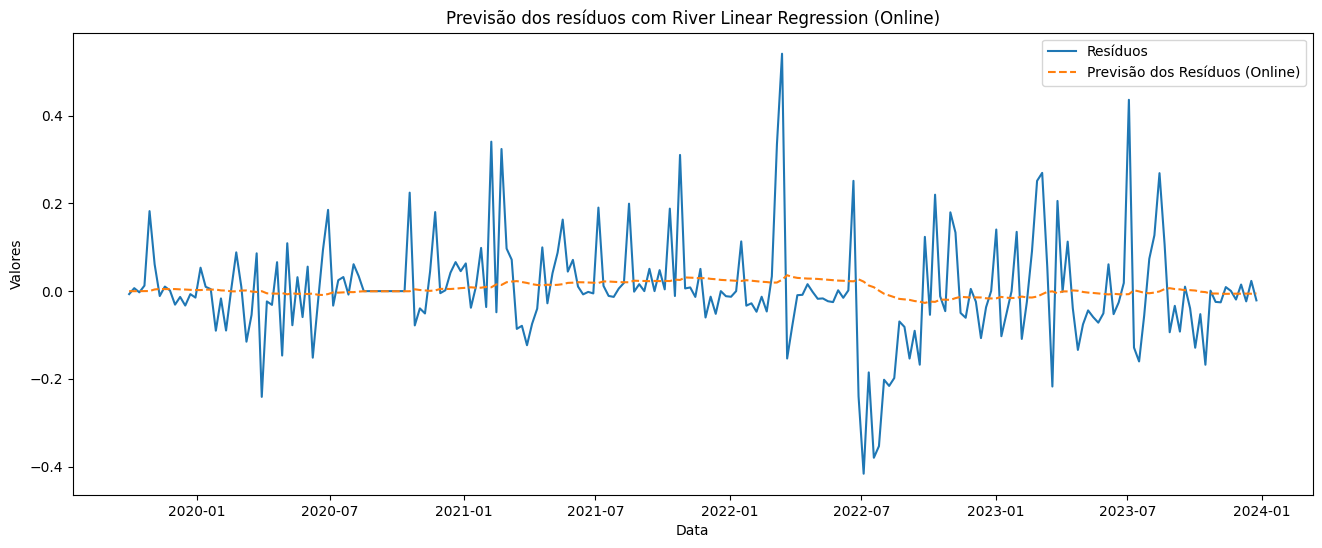

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from river import linear_model, metrics
from river import preprocessing

# Exemplo: Supondo que y_residual seja um DataFrame com um índice de tempo e duas colunas
# 'Lag_1' (feature) e 'Residual' (target)
# Certifique-se de ajustar esses nomes para o seu dataset real
data = pd.DataFrame({'Lag_1': X_residual['Lag_1'], 'Residual': y_residual})

# Modelo de regressão linear online do river
model = linear_model.LinearRegression()

# Normalizador online para manter os dados na mesma escala
scaler = preprocessing.StandardScaler()

# Métrica para avaliar o modelo
metric = metrics.MAE()

# Lista para armazenar as previsões
predictions_online = []

# Iteração online nos dados
for index, row in data.iterrows():
    x = {'Lag_1': row['Lag_1']}  # Feature
    y = row['Residual']          # Target

    # Fazer a previsão antes da atualização do modelo
    y_pred = model.predict_one(scaler.transform_one(x))
    predictions_online.append(y_pred)

    # Atualizar o modelo e o normalizador com os dados reais
    x_scaled = scaler.learn_one(x)
    model.learn_one(x_scaled, y)

    # Atualizar a métrica
    if y_pred is not None:
        metric.update(y, y_pred)

# Converter previsões para uma série para facilitar a análise
prediction_series_online = pd.Series(predictions_online, index=data.index)

print(f"Média Absoluta do Erro (MAE): {metric.get()}")
print(prediction_series_online)

# Plotar os resultados
plt.figure(figsize=(16, 6))
plt.plot(data.index, data['Residual'], label='Resíduos')
plt.plot(prediction_series_online.index, prediction_series_online, label='Previsão dos Resíduos (Online)', linestyle='--')
plt.title('Previsão dos resíduos com River Linear Regression (Online)')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.legend()
plt.show()


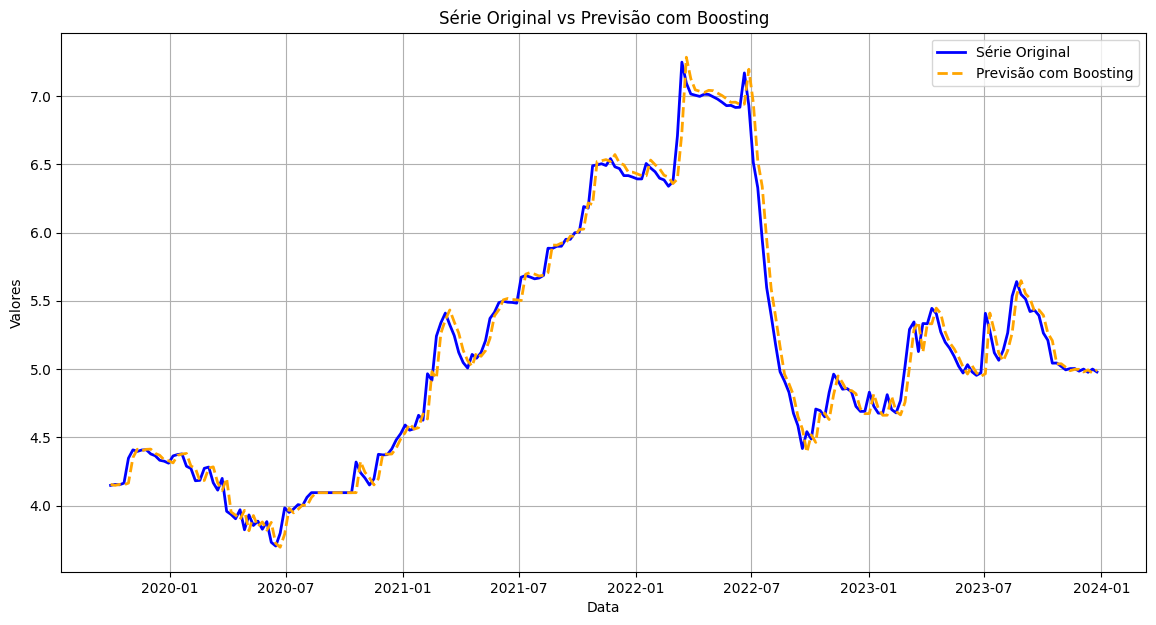

In [ ]:

# Supondo que `y_original` seja sua série original para comparar com a previsão ajustada
# Combine as previsões
y_boosted_forecast_RL = y_forecast + prediction_series_online

# Plotando a série original e a previsão ajustada com boosting
plt.figure(figsize=(14, 7))

# Plot da série original
plt.plot(y_true.index, y_true, label='Série Original', color='blue', linewidth=2)

# Plot da previsão com boosting
plt.plot(prediction_series_online.index, y_boosted_forecast_RL, label='Previsão com Boosting', color='orange', linestyle='--', linewidth=2)

# Configurações do gráfico
plt.xlabel('Data')
plt.ylabel('Valores')
plt.title('Série Original vs Previsão com Boosting')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
computeAccuracyModels(models='Boosting with RL River', y_pred=y_boosted_forecast_RL,y_true=y_true)

 --------------------------- Medidas de Erro para os Modelos  --------------------------- 
                       model       MAE      MAPE        R2     theil
1    Boosting with NORM-DICT  0.070709  0.013655  0.986304  0.792651
0                Randon Walk  0.075830  0.014760  0.982722  1.000000
2  Boosting with bayes-NORMA  0.076115  0.014875  0.983537  0.952843
4     Boosting with RL River  0.078353  0.015123  0.982672  1.002879
3        Boosting with Arima  0.081984  0.015795  0.980283  1.141136


## Holt Winters

Média Absoluta do Erro (MAE): 0.08799555540552889
Data da Coleta
2019-09-30    0.000000
2019-10-07    0.000000
2019-10-14    0.013537
2019-10-21    0.021707
2019-10-28    0.031733
                ...   
2023-11-27   -0.029218
2023-12-04   -0.026557
2023-12-11   -0.013198
2023-12-18   -0.015650
2023-12-25   -0.002198
Length: 222, dtype: float64


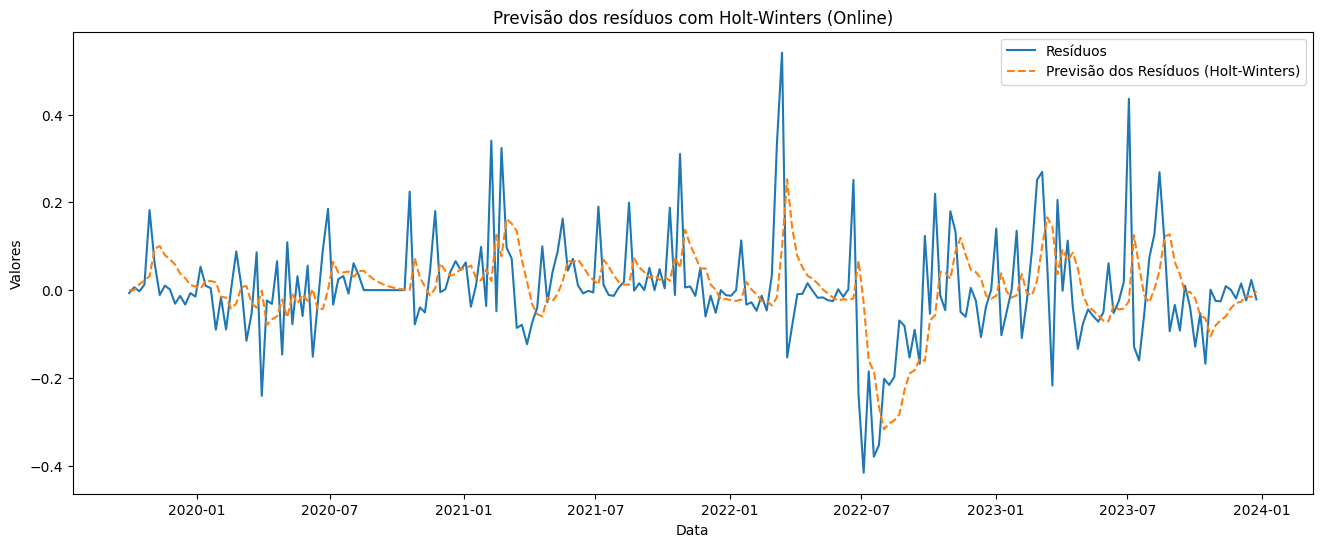

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from river import time_series, metrics

# Exemplo: Supondo que y_residual seja um DataFrame com um índice de tempo e a coluna 'Residual'
# Certifique-se de ajustar esses nomes para o seu dataset real
data = pd.DataFrame({'Residual': y_residual})

# Modelo Holt-Winters online (suavização exponencial com nível e tendência)
model = time_series.HoltWinters(alpha=0.3, beta=0.1, gamma=0.0)  # gamma=0.0 para desativar sazonalidade

# Métrica para avaliar o modelo
metric = metrics.MAE()

# Lista para armazenar as previsões
predictions_online = []

# Iteração online nos dados
for index, row in data.iterrows():
    y = row['Residual']  # Valor real do resíduo
    
    # Fazer a previsão somente após inicializar o modelo
    if len(model.level) > 0:  # Verifica se o nível foi inicializado
        y_pred = model.forecast(horizon=1)[0]
    else:
        y_pred = None  # Sem previsão inicial
    
    predictions_online.append(y_pred if y_pred is not None else 0)  # Atribui 0 se não houver previsão
    
    # Atualizar o modelo com o valor real
    model.learn_one(y)
    
    # Atualizar a métrica
    if y_pred is not None:
        metric.update(y, y_pred)

# Converter previsões para uma série para facilitar a análise
prediction_series_online = pd.Series(predictions_online, index=data.index)

print(f"Média Absoluta do Erro (MAE): {metric.get()}")
print(prediction_series_online)

# Plotar os resultados
plt.figure(figsize=(16, 6))
plt.plot(data.index, data['Residual'], label='Resíduos')
plt.plot(prediction_series_online.index, prediction_series_online, label='Previsão dos Resíduos (Holt-Winters)', linestyle='--')
plt.title('Previsão dos resíduos com Holt-Winters (Online)')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.legend()
plt.show()



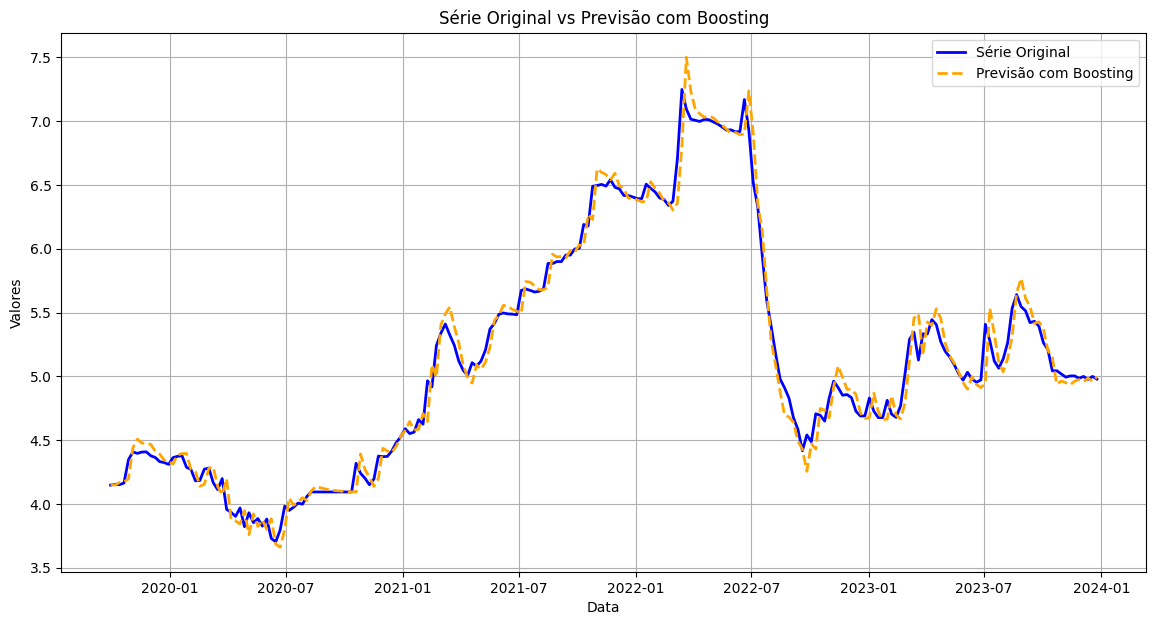

In [ ]:

# Supondo que `y_original` seja sua série original para comparar com a previsão ajustada
# Combine as previsões
y_boosted_forecast_HW = y_forecast + prediction_series_online

# Plotando a série original e a previsão ajustada com boosting
plt.figure(figsize=(14, 7))

# Plot da série original
plt.plot(y_true.index, y_true, label='Série Original', color='blue', linewidth=2)

# Plot da previsão com boosting
plt.plot(prediction_series_online.index, y_boosted_forecast_HW, label='Previsão com Boosting', color='orange', linestyle='--', linewidth=2)

# Configurações do gráfico
plt.xlabel('Data')
plt.ylabel('Valores')
plt.title('Série Original vs Previsão com Boosting')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
computeAccuracyModels(models='Boosting with HW River', y_pred=y_boosted_forecast_HW,y_true=y_true)

 --------------------------- Medidas de Erro para os Modelos  --------------------------- 
                       model       MAE      MAPE        R2     theil
1    Boosting with NORM-DICT  0.070709  0.013655  0.986304  0.792651
0                Randon Walk  0.075830  0.014760  0.982722  1.000000
2  Boosting with bayes-NORMA  0.076115  0.014875  0.983537  0.952843
4     Boosting with RL River  0.078353  0.015123  0.982672  1.002879
3        Boosting with Arima  0.081984  0.015795  0.980283  1.141136
5     Boosting with HW River  0.087264  0.017032  0.981111  1.093220
